In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import psycopg2
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sm

In [2]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres")

In [3]:
def get_open_issue_count(year, month):
    sql = f"""
        SELECT COUNT(DISTINCT issue_id) as open_issue_count, package_id, package, organization
        FROM (
            SELECT a.package_id, package, organization, a.user_id, a.issue_id, commit_pct
            FROM open_source.issue_contributors a
            INNER JOIN open_source.issues b
            ON (a.issue_id = b.id)
            WHERE b.created_at < '{year}-{month:02d}-01'
            AND (b.closed_at IS NOT NULL or b.closed_at > '{year}-{month}-01')
        ) x
        GROUP BY package_id, package, organization
    """
    data = pd.read_sql(sql, connection)
    data['date'] = f"{year}-{month}-01"
    data['date'] = pd.to_datetime(data['date'])
    return data

In [4]:
def get_contributor_count(year, month):
    sql = f"""
        SELECT COUNT(DISTINCT user_id) as contributor_count, package_id, package, organization
        FROM (
            SELECT a.package_id, package, organization, a.user_id, a.issue_id, commit_pct
            FROM open_source.issue_contributors a
            INNER JOIN open_source.issues b
            ON (a.issue_id = b.id)
            WHERE b.created_at < '{year}-{month:02d}-01'
            AND commit_pct > 0
        ) x
        GROUP BY package_id, package, organization
    """
    data = pd.read_sql(sql, connection)
    data['date'] = f"{year}-{month}-01"
    data['date'] = pd.to_datetime(data['date'])
    return data

In [5]:
test = get_open_issue_count(2020, 1)

In [6]:
test = get_contributor_count(2020, 1)

In [7]:
print(f"{1:02d}")

01


In [8]:
[x for x in test['package'] if 'aws' in x.lower()]

['saws', 'aws-sdk-php']

In [9]:
[x for x in range(1, 13)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [10]:
data = list()
for year in [2015, 2016, 2017, 2018, 2019]:
    for month in range(1, 13):
        print(f"Pulling {year}-{month}")
        open_issues = get_open_issue_count(year, month)
        contributors = get_contributor_count(year, month)
        combined = open_issues.merge(contributors, how="inner", on=["package_id", "package", "organization"])
        data.append(combined)

Pulling 2015-1
Pulling 2015-2
Pulling 2015-3
Pulling 2015-4
Pulling 2015-5
Pulling 2015-6
Pulling 2015-7
Pulling 2015-8
Pulling 2015-9
Pulling 2015-10
Pulling 2015-11
Pulling 2015-12
Pulling 2016-1
Pulling 2016-2
Pulling 2016-3
Pulling 2016-4
Pulling 2016-5
Pulling 2016-6
Pulling 2016-7
Pulling 2016-8
Pulling 2016-9
Pulling 2016-10
Pulling 2016-11
Pulling 2016-12
Pulling 2017-1
Pulling 2017-2
Pulling 2017-3
Pulling 2017-4
Pulling 2017-5
Pulling 2017-6
Pulling 2017-7
Pulling 2017-8
Pulling 2017-9
Pulling 2017-10
Pulling 2017-11
Pulling 2017-12
Pulling 2018-1
Pulling 2018-2
Pulling 2018-3
Pulling 2018-4
Pulling 2018-5
Pulling 2018-6
Pulling 2018-7
Pulling 2018-8
Pulling 2018-9
Pulling 2018-10
Pulling 2018-11
Pulling 2018-12
Pulling 2019-1
Pulling 2019-2
Pulling 2019-3
Pulling 2019-4
Pulling 2019-5
Pulling 2019-6
Pulling 2019-7
Pulling 2019-8
Pulling 2019-9
Pulling 2019-10
Pulling 2019-11
Pulling 2019-12


In [11]:
full_data = pd.concat(data)
full_data["date"] = full_data["date_x"]

In [12]:
full_data.sort_values(["package_id", "date"], inplace=True)

In [13]:
full_data.reset_index(inplace=True, drop=True)

In [14]:
full_data['package'].unique()

array(['ChakraCore', 'reveal.js', 'beets', ..., 'geotools', 'themis',
       'PyTime'], dtype=object)

In [15]:
full_data.index = full_data['date']

In [16]:
keystone = full_data[full_data['package'] == 'keystone']
keystone = keystone[keystone['date'] < '2019-05-01']

In [17]:
leaflet = full_data[full_data['package'] == 'Leaflet']
leaflet = leaflet[leaflet['date'] < '2019-01-01']

In [18]:
aws = full_data[full_data['package'] == 'Leaflet']

Text(0.5, 0, 'Date')

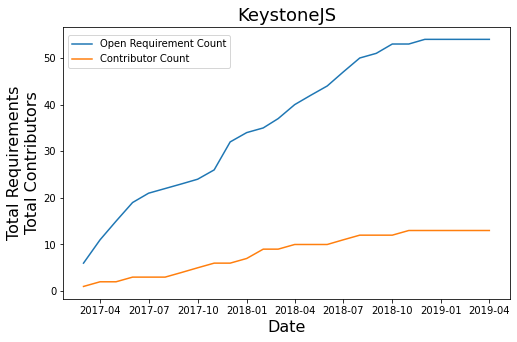

In [22]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=keystone['date'], y=keystone['open_issue_count'], label="Open Requirement Count")
sns.lineplot(x=keystone['date'], y=keystone['contributor_count'], label="Contributor Count")

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('KeystoneJS', fontsize=18)
plt.ylabel('Total Requirements\nTotal Contributors', fontsize=16)
plt.xlabel('Date', fontsize=16)

Text(0.5, 0, 'Date')

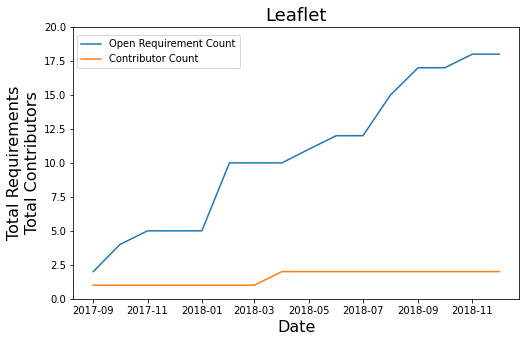

In [23]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=leaflet['date'], y=leaflet['open_issue_count'], label="Open Requirement Count")
sns.lineplot(x=leaflet['date'], y=leaflet['contributor_count'], label="Contributor Count")

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Leaflet', fontsize=18)
plt.ylim((0,20))
plt.ylabel('Total Requirements\nTotal Contributors', fontsize=16)
plt.xlabel('Date', fontsize=16)